In [1]:
import os
import sys
import matplotlib.pyplot as plt

# Use os.getcwd() to get the current working directory
main_directory = os.getcwd()
parent_directory = os.path.dirname(main_directory)
parent_directory = os.path.dirname(parent_directory)


# Define the subdirectories you want to add to sys.path
subdirs = ['MaSeq', 'marcos_client']

# Add the subdirectories to sys.path
for subdir in subdirs:
    full_path = os.path.join(parent_directory, subdir)
    sys.path.append(full_path)
#******************************************************************************


In [10]:

import pypulseq as pp
import numpy as np
import seq.mriBlankSeq as blankSeq   
import configs.units as units
import scipy.signal as sig
import experiment_multifreq as ex
import configs.hw_config_pseq as hw
import math
from flocra_pulseq.interpreter_pseq import PseqInterpreter
from pypulseq.convert import convert
from seq.utils import sort_data_implicit, plot_nd, ifft_2d, combine_coils, recon_nufft_2d
class GRERadialPSEQ(blankSeq.MRIBLANKSEQ):
    def __init__(self, nScans=None, larmorFreq=None, rfExFA=None, rfSincExTime=None,
                 repetitionTime=None, echoTime=None, fovInPlane=None, dfov=None, nPoints=None,
                 axesOrientation=None, dummyPulses=None, riseTime=None, bandwidth=None, 
                 DephTime=None, shimming=None, thickness=None, sliceGap=None, RFSpoilPhase=None,
                fsp_r=None, fsp_s=None, gx_comp=None):
        super(GRERadialPSEQ, self).__init__()
        # Input the parameters
        self.output = None
        self.expt = None
        self.nScans = np.array(nScans)
        self.larmorFreq = np.array(larmorFreq)
        self.rfExFA = np.array(rfExFA)
        self.rfSincExTime = np.array(rfSincExTime)
        self.repetitionTime = np.array(repetitionTime)
        self.echoTime = np.array(echoTime)
        self.fovInPlane = np.array(fovInPlane)
        self.dfov = np.array(dfov)
        self.nPoints = np.array(nPoints)
        self.axesOrientation = np.array(axesOrientation)
        self.dummyPulses = np.array(dummyPulses)
        self.riseTime = np.array(riseTime)
        self.bandwidth = np.array(bandwidth)
        self.DephTime = np.array(DephTime)
        self.shimming = np.array(shimming)
        self.thickness = np.array(thickness)
        self.sliceGap = np.array(sliceGap)
        self.RFSpoilPhase = np.array(RFSpoilPhase)
        self.fsp_r = np.array(fsp_r)
        self.fsp_s = np.array(fsp_s)
        self.gx_comp = np.array(gx_comp)
        # Add parameters for display and external control
        self.addParameter(key='seqName', string='tse', val='tse')
        self.addParameter(key='nScans', string='Number of scans', val=nScans, field='IM')
        self.addParameter(key='larmorFreq', string='Larmor frequency (MHz)', val=larmorFreq, units=units.MHz, field='IM')
        self.addParameter(key='rfExFA', string='Excitation flip angle (deg)', val=rfExFA, field='RF')
        self.addParameter(key='rfSincExTime', string='RF sinc excitation time (ms)', val=rfSincExTime, units=units.ms, field='RF')
        self.addParameter(key='repetitionTime', string='Repetition time (ms)', val=repetitionTime, units=units.ms, field='SEQ')
        self.addParameter(key='echoTime', string='Echo time (ms)', val=echoTime, units=units.ms, field='SEQ')
        
        self.addParameter(key='fovInPlane', string='FOV (mm)', val=fovInPlane, units=units.mm, field='IM')
        self.addParameter(key='thickness', string='Slice thickness (mm)', val=thickness, units=units.mm, field='IM')
        self.addParameter(key='sliceGap', string='Slice gap (mm)', val=sliceGap, units=units.mm, field='IM')
        self.addParameter(key='dfov', string='dFOV[x,y,z] (mm)', val=dfov, units=units.mm, field='IM',
                          tip="Position of the gradient isocenter")
        self.addParameter(key='nPoints', string='nPoints[rd, -, sl]', val=nPoints, field='IM')
        self.addParameter(key='axesOrientation', string='Axes[rd,ph,sl]', val=axesOrientation, field='IM',
                          tip="0=x, 1=y, 2=z")
        self.addParameter(key='dummyPulses', string='Dummy pulses', val=dummyPulses, field='SEQ')
        
        self.addParameter(key='bandwidth', string='Acquisition Bandwidth (kHz)', val=bandwidth, units=units.kHz, field='IM',
                          tip="The bandwidth of the acquisition (kHz). This value affects resolution and SNR.")
        self.addParameter(key='DephTime', string='Dephasing time (ms)', val=DephTime, units=units.ms, field='OTH')
        self.addParameter(key='riseTime', string='Grad. rising time (ms)', val=riseTime, units=units.ms, field='OTH')
        self.addParameter(key='shimming', string='Shimming', val=shimming, field='SEQ')
        self.addParameter(key='RFSpoilPhase', string='RF Spoiling Phase', val=RFSpoilPhase, field='OTH',
                          tip='117 deg is recommended')
        self.addParameter(key='fsp_r', string='Readout Spoiling', val=fsp_r, field='OTH',
                          tip="Gradient spoiling for readout.")
        self.addParameter(key='fsp_s', string='Slice Spoiling', val=fsp_s, field='OTH',
                          tip="Gradient spoiling for slice.")
        self.addParameter(key='gx_comp', string='gx_comp', val=gx_comp, field='OTH',
                          tip="Gradient compensation for readout.") 
     

    def sequenceTime(self):
        return (self.mapVals['repetitionTime'] *1e-3 * 
                self.mapVals['nScans'] *
                (math.ceil(self.mapVals['nPoints'][0]/2 * np.pi)-1) / 60)

    def sequenceAtributes(self):
        super().sequenceAtributes()

        # Convert files to a list
        # self.files = self.files.strip('[]').split(',')
        # self.files = [s.strip() for s in self.files]

    def sequenceRun(self, plotSeq=0, demo=False, standalone=False):
        init_gpa = False
        self.demo = demo
        self.plotSeq = plotSeq
        self.standalone = standalone
        
        # Calculate slice positions
        slice_positions = self.dfov[2] + (self.thickness + self.sliceGap) * (np.arange(self.nPoints[2]) - (self.nPoints[2] - 1) // 2)

        # slice idx
        slice_idx = np.concatenate((np.arange(self.nPoints[2])[::2],np.arange(self.nPoints[2])[1::2]))
        self.mapVals['sliceIdx'] = slice_idx

        # Reorder slices for an interleaved acquisition (optional)
        slice_positions = slice_positions[slice_idx]
        
        # redefine fov using slice thickness and gap
        self.fov = [self.fovInPlane, self.fovInPlane, np.max(slice_positions)-np.min(slice_positions)+self.thickness]       
        
        '''
        Step 1: Define the interpreter for FloSeq/PSInterpreter.
        The interpreter is responsible for converting the high-level pulse sequence description into low-level
        instructions for the scanner hardware. You will typically update the interpreter during scanner calibration.
        '''

        max_grad_Hz = convert(from_value=hw.max_grad, from_unit='mT/m', gamma=hw.gammaB, to_unit='Hz/m')
        rfExTime_us = int(np.round(self.rfSincExTime * 1e6))
        assert rfExTime_us in hw.max_sinc_rf_arr, f"RF excitation time '{rfExTime_us}' s is not found in the hw_config_pseq file; please search it in search_p90_pseq."
        max_rf_Hz = hw.max_sinc_rf_arr[rfExTime_us] * 1e-6 * hw.gammaB
        
        self.flo_interpreter = PseqInterpreter(
            tx_warmup=hw.blkTime,  # Transmit chain warm-up time (us)
            rf_center=hw.larmorFreq * 1e6 ,  # Larmor frequency (Hz)
            rf_amp_max=max_rf_Hz,  # Maximum RF amplitude (Hz)
            grad_max=max_grad_Hz,  # Maximum gradient amplitude (Hz/m)
            grad_t=10,  # Gradient raster time (us)
            orientation=self.axesOrientation, # gradient orientation
            grad_eff=hw.gradFactor, # gradient coefficient of efficiency
            use_multi_freq = True,
            add_rx_points = 0,
            tx_t= 1229/122.88, # us
            use_grad_preemphasis=False,
            grad_preemphasis_coeff={
                        'zz':( (np.array([1.8061, 1.391, 0.2535, -0.0282]) * 1e-2, 
                            np.array([1567, 17510, 167180, 608533] ))),
                        'xx':( (np.array([-0.3031, 0.0782, 0.0227, 0.0]) * 1e-2,
                            np.array([2537, 87749, 986942, 0.1] ))),
                        'yy':( (np.array([1.7434, 2.0108, 0.4076, -0.1527]) *1e-2,
                            np.array([2151, 24193, 321545, 989703] ))),
                 },
            use_fir_decimation = (self.bandwidth < 30.007326007326007e3), # 30kHz
        )
        
        '''
        Step 2: Define system properties using PyPulseq (pp.Opts).
        These properties define the hardware capabilities of the MRI scanner, such as maximum gradient strengths,
        slew rates, and dead times. They are typically set based on the hardware configuration file (`hw_config`).
        '''
        self.system = pp.Opts(
            rf_dead_time=100 * 1e-6,  # Dead time between RF pulses (s)
            max_grad=38,  # Maximum gradient strength (mT/m)
            grad_unit='mT/m',  # Units of gradient strength
            max_slew=hw.max_slew_rate,  # Maximum gradient slew rate (mT/m/ms)
            slew_unit='mT/m/ms',  # Units of gradient slew rate
            grad_raster_time=hw.grad_raster_time, # hw.grad_raster_time,  # Gradient raster time (s)
            rise_time=hw.grad_rise_time,  # Gradient rise time (s)
            rf_raster_time=10e-6,
            block_duration_raster=1e-6,
            adc_raster_time=1/(122.88e6),
            adc_dead_time=0e-6,
            rf_ringdown_time=100e-6,
            

        )

        '''
        Step 3: Perform any calculations required for the sequence.
        In this step, students can implement the necessary calculations, such as timing calculations, RF amplitudes, and
        gradient strengths, before defining the sequence blocks.
        '''

        bw = self.bandwidth * 1e-6 # MHz
        bw_ov = self.bandwidth * 1e-6 # - hw.oversamplingFactor  # MHz
        sampling_period = 1 / bw_ov  # us, Dwell time

        '''
        Step 4: Define the experiment to get the true bandwidth
        In this step, student needs to get the real bandwidth used in the experiment. To get this bandwidth, an
        experiment must be defined and the sampling period should be obtained using get_rx_ts()[0]
        '''

        if not self.demo:
            expt = ex.ExperimentMultiFreq(
                lo_freq=hw.larmorFreq,  # Larmor frequency in MHz
                rx_t=sampling_period,  # Sampling time in us
                init_gpa=False,  # Whether to initialize GPA board (False for True)
                gpa_fhdo_offset_time=(1 / 0.2 / 3.1),  # GPA offset time calculation
                auto_leds=True  # Automatic control of LEDs (False or True)
            )
            sampling_period = expt.get_rx_ts()[0]  # us
            bw = 1 / sampling_period # / hw.oversamplingFactor  # MHz
            print("Acquisition bandwidth fixed to: %0.3f kHz" % (bw * 1e3))
            expt.__del__()
        self.mapVals['bw_MHz'] = bw
        self.mapVals['sampling_period_us'] = sampling_period

        '''
        Step 5: Define sequence blocks.
        In this step, you will define the building blocks of the MRI sequence, including the RF pulses and gradient pulses.
        '''
        TE = self.echoTime
        TR = self.repetitionTime
        N_dummy = self.dummyPulses
        
        rf_spoiling_inc = self.RFSpoilPhase
          
        Nx, Ny, n_slices = self.nPoints
        Nr = (math.ceil(Nx / 2 * np.pi) - 1)
        delta = np.pi / Nr
        sampling_time = sampling_period * 1e-6 * self.nPoints[0]
        readout_time = sampling_time + 2 * self.system.adc_dead_time
        
        rf, gz, _ = pp.make_sinc_pulse(
            flip_angle=self.rfExFA * np.pi / 180,
            duration=self.rfSincExTime,
            slice_thickness=self.thickness,
            apodization=0.5,
            time_bw_product=4,
            system=self.system,
            phase_offset= np.pi / 2,
            return_gz=True
        )

        gz_reph = pp.make_trapezoid(channel="z", area=-gz.area / 2, duration=self.DephTime, system=self.system)
        # Define other gradients and ADC events
        deltak = 1 / self.fovInPlane
        gx = pp.make_trapezoid(channel="x", flat_area=Nx * deltak, flat_time=readout_time, system=self.system)
        adc = pp.make_adc(num_samples=Nx, duration=gx.flat_time, delay=gx.rise_time, system=self.system)
        gx_pre = pp.make_trapezoid(channel="x", area=-gx.area * self.gx_comp, duration=self.DephTime, system=self.system)

        # Gradient spoiling
        gx_spoil = pp.make_trapezoid(channel="x", area=self.fsp_r * Nx * deltak, duration=self.DephTime, system=self.system)
        gz_spoil = pp.make_trapezoid(channel="z", area=self.fsp_s / self.thickness, duration=self.DephTime, system=self.system)

        
        # Calculate timing
        delay_TE = (
            np.ceil(
                (
                    TE
                    - (pp.calc_duration(gz, rf) - pp.calc_rf_center(rf)[0] - rf.delay)
                    - pp.calc_duration(gx_pre, gz_reph)
                    - pp.calc_duration(gx) / 2
                    - pp.eps
                )
                / self.system.grad_raster_time
            )
            * self.system.grad_raster_time
        )

        delay_TR = (
            np.ceil(
                (
                    TR
                    - pp.calc_duration(gz, rf)
                    - pp.calc_duration(gx_pre, gz_reph)
                    - pp.calc_duration(gx)
                    - delay_TE
                )
                / self.system.grad_raster_time
            )
            * self.system.grad_raster_time
        )
        assert delay_TE >= 0, f"delay_TE '{delay_TE}' should be greater than 0."
        
        assert delay_TR >= pp.calc_duration(gx_spoil, gz_spoil), f"delay_TR '{delay_TR}' should be greater than spoil time {gx_spoil}, {gz_spoil}."
        

        def runBatches_pseq(waveforms, n_readouts, frequency=hw.larmorFreq, bandwidth=0.03):
            """
            Execute multiple batches of waveforms for MRI data acquisition, handle scanning, and store oversampled data.

            Parameters:
            -----------
            waveforms : dict
                A dictionary of waveform sequences, where each key corresponds to a batch identifier and
                the value is the waveform data generated using PyPulseq.
            n_readouts : dict
                A dictionary that specifies the number of readout points for each batch. Keys correspond to
                the batch identifiers, and values specify the number of readout points for each sequence.
            frequency : float, optional
                Larmor frequency in MHz for the MRI scan (default is the system's Larmor frequency, hw.larmorFreq).
            bandwidth : float, optional
                Bandwidth in Hz used to calculate the sampling time (1 / bandwidth gives the sampling period).

            Returns:
            --------
            bool
                Returns True if all batches were successfully executed, and False if an error occurred (e.g.,
                sequence waveforms are out of hardware bounds).

            Notes:
            ------
            - The method will initialize the Red Pitaya hardware if not in demo mode.
            - The method converts waveforms from PyPulseq format to Red Pitaya compatible format.
            - If plotSeq is True, the sequence will be plotted instead of being executed.
            - In demo mode, the acquisition simulates random data instead of using actual hardware.
            - Oversampled data is stored in the class attribute `self.mapVals['data_over']`.
            - Data points are acquired in batches, with error handling in case of data loss, and batches are repeated if necessary.
            """
            

            # Initialize a list to hold oversampled data
            data_over = []
            real_bandwidth = bandwidth * self.flo_interpreter._fir_decimation_rate 
            
            # Iterate through each batch of waveforms
            for seq_num in waveforms.keys():
                # Initialize the experiment if not in demo mode
                if not self.demo:
                    self.expt = ex.ExperimentMultiFreq(
                        lo_freq=frequency,  # Larmor frequency in MHz
                        rx_t=1 / real_bandwidth,  # Sampling time in us
                        init_gpa=False,  # Whether to initialize GPA board (False for now)
                        gpa_fhdo_offset_time=(1 / 0.2 / 3.1),  # GPA offset time calculation
                        auto_leds=True,  # Automatic control of LEDs
                        allow_user_init_cfg=True # Allow lo*_freq and lo*_rst to be modified
                    )
                print(f"Center frequecy set: {frequency} MHz")
                # Convert the PyPulseq waveform to the Red Pitaya compatible format
                self.pypulseq2mriblankseq_ms(waveforms=waveforms[seq_num], shimming=self.shimming)

                # Load the waveforms into Red Pitaya
                if not self.floDict2Exp_ms():
                    print("ERROR: Sequence waveforms out of hardware bounds")
                    return False
                else:
                    encoding_ok = True
                    # print("Sequence waveforms loaded successfully")
                if self.plotSeq and not self.demo:
                    self.expt.plot_sequence()

                # If not plotting the sequence, start scanning
                if not self.plotSeq:
                    for scan in range(self.nScans):
                        print(f"Scan {scan + 1}, batch {seq_num.split('_')[-1]}/{1} running...")
                        acquired_points = 0
                        expected_points = n_readouts[seq_num] * self.flo_interpreter._fir_decimation_rate * hw.oversamplingFactor  # Expected number of points

                        # Continue acquiring points until we reach the expected number
                        while acquired_points != expected_points:
                            if not self.demo:
                                rxd, msgs = self.expt.run()  # Run the experiment and collect data
                            else:
                                # In demo mode, generate random data as a placeholder
                                rxd = {'rx0': np.random.randn(expected_points + self.flo_interpreter.get_add_rx_points()) + 1j * np.random.randn(expected_points + + self.flo_interpreter.get_add_rx_points())}
                            
                            # Update acquired points
                            self.rxChName = 'rx0'
                            rx_raw_data = rxd[self.rxChName]
                            rxdata = self.flo_interpreter.rx_points_added_for_img(rx_raw_data, self.nPoints[0])
                            rxdata = np.reshape(rxdata, newshape=(-1))
                            acquired_points = np.size(rxdata)

                            # Check if acquired points coincide with expected points
                            if acquired_points != expected_points:
                                print("WARNING: data apoints lost!")
                                print("Repeating batch...")

                        # Concatenate acquired data into the oversampled data array
                        data_over = np.concatenate((data_over, rxdata), axis=0)
                        print(f"Acquired points = {acquired_points}, Expected points = {expected_points}")
                        print(f"Scan {scan + 1}, batch {seq_num[-1]}/{1} ready!")

                    # Decimate the oversampled data and store it
                    self.mapVals['data_over'] = data_over
                    self.mapVals['data_full'] = np.concatenate((self.mapVals['data_full'], self.mapVals['data_over']), axis=0)
                    
                elif self.plotSeq and self.standalone:
                    # Plot the sequence if requested and return immediately
                    self.sequencePlot(standalone=self.standalone)

                if not self.demo:
                    self.expt.__del__()

            return True
        
        
        # Initialize batches dictionary to store different parts of the sequence.
        batches = {}
        n_rd_points_dict = {}  # Dictionary to track readout points for each batch
        n_rd_points = 0
        batch_idx = 1 # In this sequence, batch_idx is equivalent to the index of slice coding index 

        
        '''
        Step 7: Define your createBatches method.
        In this step you will populate the batches adding the blocks previously defined in step 4, and accounting for
        number of acquired points to check if a new batch is required.
        '''
        def createBatches():
            """
            Create batches for the full pulse sequence.

            Instructions:
            - This function creates the complete pulse sequence by iterating through repetitions.
            - Each iteration adds new blocks to the sequence, including the RF pulse, ADC block, and repetition delay.
            - If a batch exceeds the maximum number of readout points, a new batch is started.

            Returns:
                waveforms (dict): Contains the waveforms for each batch.
                n_rd_points_dict (dict): Dictionary of readout points per batch.
            """
            
            n_rd_points = 0
            rf_phase = 0
            rf_inc = 0
            for s in range(n_slices):    
                # slice offset
                rf_freq_offset_slice = gz.amplitude * slice_positions[s]
                rf_phase_offset_slice = 0 - 2 * np.pi * rf.freq_offset * pp.calc_rf_center(rf)[0]
                adc_phase_offset_slice = rf_phase_offset_slice
                for i in range(-N_dummy, Nr):
                     

                    # Set RF/ADC freq/phase for RF spoiling, and increment RF phase
                    rf.freq_offset = rf_freq_offset_slice
                    rf.phase_offset = rf_phase / 180 * np.pi + rf_phase_offset_slice
                    adc.phase_offset = rf_phase / 180 * np.pi + adc_phase_offset_slice

                    rf_inc = (rf_inc + rf_spoiling_inc) % 360.0
                    rf_phase = (rf_phase + rf_inc) % 360.0

                    # Slice-selective excitation pulse
                    batches[batch_num].add_block(rf, gz)

                    # Slice rephaser and readout pre-phaser
                    phi = delta * (i)
                    batches[batch_num].add_block(*pp.rotate(gx_pre, angle=phi, axis="z"), gz_reph)

                    # Wait so readout is centered on TE
                    batches[batch_num].add_block(pp.make_delay(delay_TE))

                    # Readout gradient, rotated by `phi`
                    if i >= 0:
                        # Real scan, readout gradient + ADC object
                        batches[batch_num].add_block(*pp.rotate(gx, angle=phi, axis="z"), adc)
                        assert n_rd_points + self.nPoints[0] < hw.maxRdPoints
                        n_rd_points = n_rd_points + self.nPoints[0]
                    else:
                        # Dummy scan, do not add ADC object
                        batches[batch_num].add_block(*pp.rotate(gx, angle=phi, axis="z"))

                    # GX/GZ spoiler gradient, and wait for TR
                    batches[batch_num].add_block(*pp.rotate(gx_spoil, angle=phi, axis="z"), gz_spoil, pp.make_delay(delay_TR))
            
            (
                ok,
                error_report,
            ) = batches[batch_num].check_timing()  # Check whether the timing of the sequence is correct
            
            if plotSeq:
                if ok:
                    print("Timing check passed successfully")
                else:
                    print("Timing check failed. Error listing follows:")
                    [print(e) for e in error_report]
                
                k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = batches[batch_num].calculate_kspace()
                deltak_edge = np.linalg.norm(k_traj_adc[:,adc.num_samples-1] - k_traj_adc[:,2*adc.num_samples-1])
                if deltak_edge >= deltak*1.001: # Allow for small error
                    print(f'Not Nyquist sampled! {deltak / deltak_edge * 100:.1f}% ')
                else:
                    print(f'Nyquist sampled! {deltak / deltak_edge * 100:.1f}% ')
                
                print(batches[batch_num].test_report())
                batches[batch_num].plot()
                k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = batches[batch_num].calculate_kspace()

                plt.figure(10)
                plt.plot(k_traj[0],k_traj[1],linewidth=1)
                plt.plot(k_traj_adc[0],k_traj_adc[1],'.', markersize=1.4)
                plt.axis("equal")
                plt.title("k-space trajectory (kx/ky)")

                plt.figure(11)
                plt.plot(t_adc, k_traj_adc.T, linewidth=1)
                plt.xlabel("Time of acqusition (s)")
                plt.ylabel("Phase")
                
                plt.figure(12)
                t = np.linspace(0, 1, k_traj_adc.shape[1])  # 归一化时间
                plt.scatter(k_traj_adc[0], k_traj_adc[1], c=t, cmap='viridis', s=2)  # 用颜色表示时间
                plt.axis("equal")
                plt.colorbar(label='Normalized Time')  # 添加颜色条
                plt.title("k-space trajectory (kx/ky) with Gradient")
                plt.show()

            batches[batch_num].set_definition(key="Name", value="gre_radial")
            batches[batch_num].set_definition(key="FOV", value=self.fov)
            batches[batch_num].write(f"gre_radial_{batch_num}.seq")
            self.waveforms[batch_num], param_dict = self.flo_interpreter.interpret(f"gre_radial_{batch_num}.seq")
            print(f"gre_radial_{batch_num}.seq ready!")
            print(f"{len(batches)} batches created with {n_rd_points} read points. Sequence ready!")

            # Update the number of acquired ponits in the last batch
            self.n_rd_points_dict[batch_num] = n_rd_points
            self.lastseq = batches[batch_num]

            return 

        '''
        Step 8: Run the batches
        This step will handle the different batches, run it and get the resulting data. This should not be modified.
        Oversampled data will be available in self.mapVals['data_over']
        '''
        self.waveforms = {}  # Dictionary to store generated waveforms
        self.n_rd_points_dict = {}
        # self.rf_slice_freq_offset = []
        self.mapVals['data_full'] = []
        
            
        batch_num = f"batch_{batch_idx}"  # Initial batch name
        print(f"Creating {batch_num}.seq...")
        batches[batch_num] = pp.Sequence(system=self.system)

        createBatches()

        batches_list = [{key: value} for key, value in self.waveforms.items()]
        n_rd_points_list = [{key: value} for key, value in self.n_rd_points_dict.items()]
        
        assert runBatches_pseq(batches_list[0],
                            n_rd_points_list[0],
                            frequency=(self.larmorFreq)*1e-6 ,  # MHz
                            bandwidth=bw_ov,  # MHz
                            )
            
        self.mapVals['n_readouts'] = list(self.n_rd_points_dict.values())
        self.mapVals['n_batches'] = 1
        self.mapVals['Nr'] = Nr
        return True

        
    def sequenceAnalysis(self, mode=None, lambda_tv=0.0):
        self.mode = mode
        
        #self.axesOrientation = [0,1,2] # for ssfp
        self.unlock_orientation = 0 # for ssfp
        resolution = self.fov / self.nPoints
        self.mapVals['resolution'] = resolution

        # Get data
        data_full_pre = self.mapVals['data_full']
        nRD, _, nSL = self.nPoints
        nRadial = self.mapVals['Nr']
        nRD = nRD + 2 * hw.addRdPoints
        n_batches = self.mapVals['n_batches']

        # fir decimator
        if self.flo_interpreter._fir_decimation_rate > 1:
            data_waiting_for_fir = np.reshape(data_full_pre, newshape=(-1, self.flo_interpreter._fir_decimation_rate * nRD))
            data_full = self.flo_interpreter.fir_decimator(input_matrix=data_waiting_for_fir, decimation_rate=3)
        else:
            data_full = data_full_pre

        # Reorganize data_full
        data_prov = np.zeros([self.nScans, nRD * nRadial * nSL], dtype=complex)
        if n_batches > 1:
            n_rds = self.mapVals['n_readouts']
            data_full_a = data_full[0:sum(n_rds[0:-1]) * self.nScans]
            data_full_b = data_full[sum(n_rds[0:-1]) * self.nScans:]
            data_full_a = np.reshape(data_full_a, newshape=(n_batches - 1, self.nScans, -1, nRD))
            data_full_b = np.reshape(data_full_b, newshape=(1, self.nScans, -1, nRD))
            for scan in range(self.nScans):
                data_scan_a = np.reshape(data_full_a[:, scan, :, :], -1)
                data_scan_b = np.reshape(data_full_b[:, scan, :, :], -1)
                data_prov[scan, :] = np.concatenate((data_scan_a, data_scan_b), axis=0)
        else:
            data_full = np.reshape(data_full, (1, self.nScans, -1, nRD))
            for scan in range(self.nScans):
                data_prov[scan, :] = np.reshape(data_full[:, scan, :, :], -1)
        
        # [TODO]: Add Rx phase here
        expiangle = self.flo_interpreter.get_rx_phase_dict()['rx0']
        raw_data = np.reshape(data_prov, newshape=(1, self.nScans, -1, nRD))
        for scan in range(self.nScans):
            for line in range(raw_data.shape[2]):
                raw_data[0, scan, line, :] = raw_data[0, scan, line, :] * expiangle[line]
        data_full = np.reshape(raw_data, -1)
        
        # Average data
        data_full = np.reshape(data_full, newshape=(self.nScans, -1))
        data = np.average(data_full, axis=0)
        self.mapVals['data'] = data

        # slice_idx = self.mapVals['sliceIdx']
        n_ex = nRadial
        data_shape = np.reshape(data, newshape=(n_ex, nSL, 1, nRD))
        
        kdata_input = np.reshape(data_shape, newshape=(1, -1, nRD))
        data_ind = np.reshape(kdata_input, newshape=(1, nSL, nRadial, nRD))
        self.mapVals['kSpace'] = data_ind
     
        # plot #0 slice: #####################################
        # first_slice_kspace = np.reshape(data_ind[0, 0, :, :], newshape=(nPH, nRD))
        # plot_nd(first_slice_kspace, vmax=10)
        # plt.title('K-space')
        ######################################################

        
        # Get images
        
        image_ind = recon_nufft_2d(kdata_input, self.lastseq, (nRD, nRD), lambda_tv=lambda_tv)
        print(image_ind.shape)
        self.mapVals['iSpace'] = image_ind
        
        # Prepare data to plot (plot central slice)
        axes_dict = {'x': 0, 'y': 1, 'z': 2}
        axes_keys = list(axes_dict.keys())
        axes_vals = list(axes_dict.values())
        axes_str = ['', '', '']
        n = 0
        for val in self.axesOrientation:
            index = axes_vals.index(val)
            axes_str[n] = axes_keys[index]
            n += 1

        # Normalize image
        k_space = np.zeros((nSL, nRadial, nRD - 2 * hw.addRdPoints))
        image = np.zeros(( nSL, nRD, nRD - 2 * hw.addRdPoints))

        
        n = 0
        for slice in range(nSL):
            for echo in range(1):
                k_space[n, :, :] = np.abs(data_ind[echo, slice, :, :])
                image[n, :, :] = np.abs(image_ind[ :, :])
                n += 1
        image = image / np.max(image) * 100
        # plt.plot(np.real(k_space[0,0,:]))
        # plt.show()
        imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        if not self.unlock_orientation:  # Image orientation
            pass
            if self.axesOrientation[2] == 2:  # Sagittal
                title = "Sagittal"
                if self.axesOrientation[0] == 0 and self.axesOrientation[1] == 1:  # OK
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(-Y) A | READOUT2 | P (+Y)"
                    y_label = "(-X) I | READOUT1 | S (+X)"
                    imageOrientation_dicom = [0.0, 1.0, 0.0, 0.0, 0.0, -1.0]
                else:
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(-Y) A | READOUT1 | P (+Y)"
                    y_label = "(-X) I | READOUT2 | S (+X)"
                    imageOrientation_dicom = [0.0, 1.0, 0.0, 0.0, 0.0, -1.0]
            elif self.axesOrientation[2] == 1:  # Coronal
                title = "Coronal"
                if self.axesOrientation[0] == 0 and self.axesOrientation[1] == 2:  # OK
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    image = np.flip(image, axis=0)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    k_space = np.flip(k_space, axis=0)
                    x_label = "(+Z) R | READOUT2 | L (-Z)"
                    y_label = "(-X) I | READOUT1 | S (+X)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 0.0, -1.0]
                else:
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    image = np.flip(image, axis=0)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    k_space = np.flip(k_space, axis=0)
                    x_label = "(+Z) R | READOUT1 | L (-Z)"
                    y_label = "(-X) I | READOUT2 | S (+X)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 0.0, -1.0]
            elif self.axesOrientation[2] == 0:  # Transversal
                title = "Transversal"
                if self.axesOrientation[0] == 1 and self.axesOrientation[1] == 2:
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(+Z) R | READOUT2 | L (-Z)"
                    y_label = "(+Y) P | READOUT1 | A (-Y)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
                else:  # OK
                    image = np.transpose(image, (0, 2, 1))
                    image = np.flip(image, axis=2)
                    image = np.flip(image, axis=1)
                    k_space = np.transpose(k_space, (0, 2, 1))
                    k_space = np.flip(k_space, axis=2)
                    k_space = np.flip(k_space, axis=1)
                    x_label = "(+Z) R | READOUT1 | L (-Z)"
                    y_label = "(+Y) P | READOUT2 | A (-Y)"
                    imageOrientation_dicom = [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]
        else:
            x_label = "%s axis" % axes_str[1]
            y_label = "%s axis" % axes_str[0]
            title = "Image"

        result1 = {'widget': 'image',
                   'data': image,
                   'xLabel': x_label,
                   'yLabel': y_label,
                   'title': title,
                   'row': 0,
                   'col': 0}

        result2 = {'widget': 'image',
                   'data': np.log10(k_space+0.01),
                   'xLabel': x_label,
                   'yLabel': y_label,
                   'title': "k_space",
                   'row': 0,
                   'col': 1}
 

        # Dicom tags
        image_DICOM = np.transpose(image, (0, 2, 1))
        slices, rows, columns = image_DICOM.shape
        self.meta_data["Columns"] = columns
        self.meta_data["Rows"] = rows
        self.meta_data["NumberOfSlices"] = slices
        self.meta_data["NumberOfFrames"] = slices
        img_full_abs = np.abs(image_DICOM) * (2 ** 15 - 1) / np.amax(np.abs(image_DICOM))
        img_full_int = np.int16(np.abs(img_full_abs))
        img_full_int = np.reshape(img_full_int, newshape=(slices, rows, columns))
        arr = img_full_int
        self.meta_data["PixelData"] = arr.tobytes()
        self.meta_data["WindowWidth"] = 26373
        self.meta_data["WindowCenter"] = 13194
        self.meta_data["ImageOrientationPatient"] = imageOrientation_dicom
        resolution = self.mapVals['resolution'] * 1e3
        self.meta_data["PixelSpacing"] = [resolution[0], resolution[1]]
        self.meta_data["SliceThickness"] = resolution[2]
        # Sequence parameters
        self.meta_data["RepetitionTime"] = self.mapVals['repetitionTime']
        self.meta_data["EchoTime"] = self.mapVals['echoTime']
        self.meta_data["FlipAngle"] = [self.mapVals['rfExFA']]
        self.meta_data["NumberOfAverages"] = self.mapVals['nScans']
        

        self.meta_data["ScanningSequence"] = 'GRE'

        # create self.out to run in iterative mode
        self.output = [result1, result2]

        # save data once self.output is created
        self.saveRawData()

        # Plot result in standalone execution
        if self.mode == 'Standalone':
            self.plotResults()

        return self.output
  



Sequence total time: 0.0 min 10.05 seconds!
Acquisition bandwidth fixed to: 21.333 kHz
Creating batch_1.seq...
read 6 definitions, 1005 blocks, 2 shapes, 24 adc events, 24 rf events, 906 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 25728 read points. Sequence ready!
Center frequecy set: 10.53 MHz
Scan 1, batch 1/1 running...


/home/lks/MaSeq_pack/marcos_client/marcompile.py:245: MarGradWarning: Gradient updates are too frequent for selected SPI divider. Missed samples are likely!
  warnings.warn("Gradient updates are too frequent for selected SPI divider. Missed samples are likely!", MarGradWarning)
/home/lks/MaSeq_pack/marcos_client/marcompile.py:309: UserWarning: NOTE: Fewer than 1000 removed-instruction warnings will not be printed -- keep this in mind when searching for the root cause.
  warnings.warn("NOTE: Fewer than {:d} removed-instruction warnings will not be printed -- keep this in mind when searching for the root cause.".format(max_removed_instructions))
/home/lks/MaSeq_pack/marcos_client/server_comms.py:86: MarServerWarning: ocra1 data was lost (overwritten before being sent)
  warnings.warn(k, MarServerWarning)
/home/lks/MaSeq_pack/marcos_client/server_comms.py:93: RuntimeWarning: SERVER ERROR: memory buffer underrun around byte address 0xc0000
  warnings.warn("SERVER ERROR: " + k, RuntimeWarni

Repeating batch...
Acquired points = 77184, Expected points = 77184
Scan 1, batch 1/1 ready!
------------ max abs value: 0.0003327471625002617


LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  6.00it/s, resid=3.36E-03]


(128, 128)
Moved: raw_data_20250428_132636 to experiments/acquisitions/2025.04.28


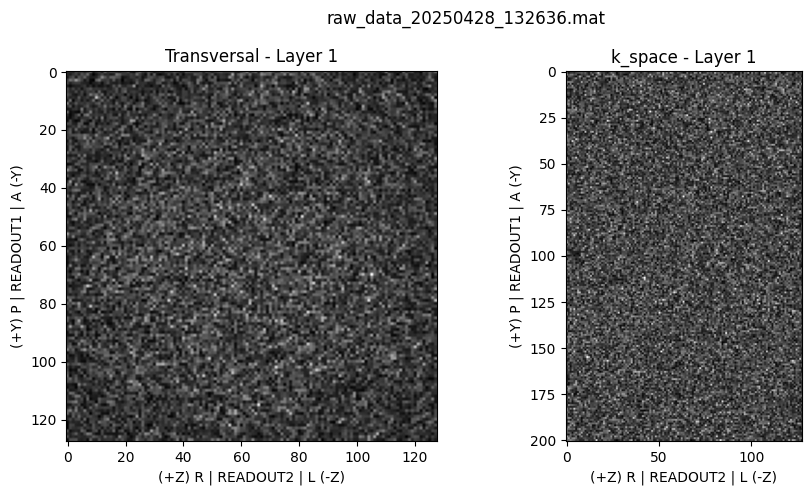

[{'widget': 'image',
  'data': array([[[17.28434732, 17.21135707, 13.39180189, ..., 34.26270656,
           26.46848974, 50.34322506],
          [15.69422663, 11.32127496, 20.72508344, ..., 34.40201123,
           18.8180811 , 15.20427373],
          [ 9.56039201, 23.92652903, 31.32290155, ..., 44.90689204,
           16.58721681,  8.45314224],
          ...,
          [18.77209086, 13.91810831, 24.36739499, ..., 16.78191133,
            6.11497501, 20.43901437],
          [33.52866357, 12.18130314, 16.99142499, ..., 12.49906166,
           26.15235571, 17.8866956 ],
          [ 5.38235048, 30.69446993, 30.62305075, ...,  4.86197071,
           19.31470231, 11.3775767 ]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.99655271, -1.99815407, -1.99380701, ..., -1.99895073,
           -1.99695986, -1.99849533],
          [-1.99572442, -1.9992727 , -1.9980212

In [3]:

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53, rfExFA=90, rfSincExTime=3.0, repetitionTime=50.0, 
    echoTime=9.0, fovInPlane=250, dfov=[0.0, 0.0, 12.0], nPoints=[128, 128, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=0, riseTime=0.25, bandwidth=21.3333333333333333, 
    DephTime=2.0, shimming=[0.0015, 0.0019, 0.0005], thickness=5.0, 
    sliceGap=1.0, RFSpoilPhase=117, fsp_r=0.5, fsp_s=4   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)


Sequence total time: 0.0 min 10.05 seconds!
Acquisition bandwidth fixed to: 32.000 kHz
Creating batch_1.seq...
read 6 definitions, 1005 blocks, 2 shapes, 24 adc events, 24 rf events, 906 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 25728 read points. Sequence ready!
Center frequecy set: 10.53 MHz
Scan 1, batch 1/1 running...


/home/lks/MaSeq_pack/marcos_client/marcompile.py:245: MarGradWarning: Gradient updates are too frequent for selected SPI divider. Missed samples are likely!
  warnings.warn("Gradient updates are too frequent for selected SPI divider. Missed samples are likely!", MarGradWarning)
/home/lks/MaSeq_pack/marcos_client/marcompile.py:309: UserWarning: NOTE: Fewer than 1000 removed-instruction warnings will not be printed -- keep this in mind when searching for the root cause.
  warnings.warn("NOTE: Fewer than {:d} removed-instruction warnings will not be printed -- keep this in mind when searching for the root cause.".format(max_removed_instructions))
/home/lks/MaSeq_pack/marcos_client/server_comms.py:86: MarServerWarning: ocra1 data was lost (overwritten before being sent)
  warnings.warn(k, MarServerWarning)


Acquired points = 25728, Expected points = 25728
Scan 1, batch 1/1 ready!
------------ max abs value: 0.00021061113827046046


LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  6.02it/s, resid=2.81E-03]


(128, 128)
Moved: raw_data_20250428_132808 to experiments/acquisitions/2025.04.28


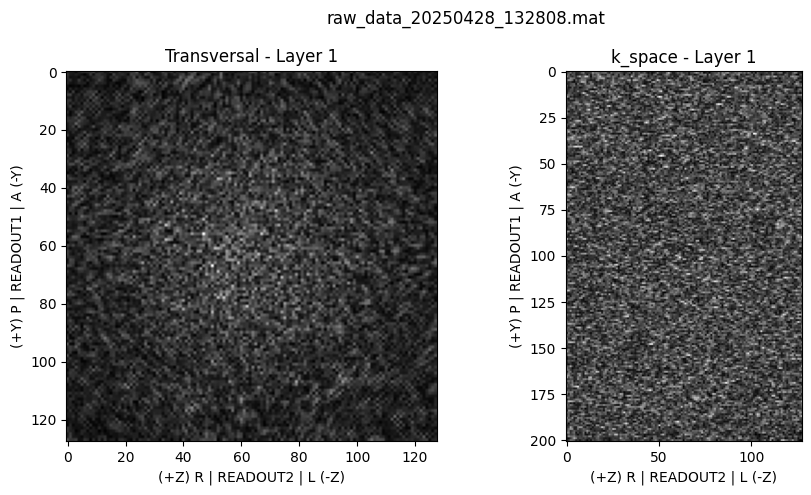

[{'widget': 'image',
  'data': array([[[12.42764278, 11.75625366, 10.68276576, ...,  2.84255616,
           15.24424235,  4.78542651],
          [21.62452977, 10.8040204 ,  9.14609833, ..., 17.68030124,
            8.97929127,  9.64349141],
          [18.2076134 ,  6.05675771,  7.60063952, ...,  5.15005804,
           10.72923439,  3.46410461],
          ...,
          [11.59325523, 24.28151504, 10.32741039, ...,  7.51767666,
           16.38234878,  8.080455  ],
          [13.25950484, 25.69940873,  9.56705153, ..., 19.21395581,
            4.39731585, 13.13849646],
          [33.24772989, 21.16512522, 21.04820258, ...,  4.17794312,
           15.42815194, 16.88310645]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.99915779, -1.99953867, -1.99815603, ..., -1.99923751,
           -1.99667204, -1.99767939],
          [-1.99757564, -1.99723298, -1.9960172

In [4]:

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53, rfExFA=90, rfSincExTime=3.0, repetitionTime=50.0, 
    echoTime=9.0, fovInPlane=250, dfov=[0.0, 0.0, 12.0], nPoints=[128, 128, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=0, riseTime=0.25, bandwidth=32, 
    DephTime=2.0, shimming=[0.0015, 0.0019, 0.0005], thickness=5.0, 
    sliceGap=1.0, RFSpoilPhase=117, fsp_r=0.5, fsp_s=4   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)


Sequence total time: 0.0 min 10.05 seconds!
Acquisition bandwidth fixed to: 21.333 kHz
Creating batch_1.seq...
read 6 definitions, 1005 blocks, 2 shapes, 24 adc events, 24 rf events, 906 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 25728 read points. Sequence ready!
Center frequecy set: 10.53223 MHz
Scan 1, batch 1/1 running...
Acquired points = 77184, Expected points = 77184
Scan 1, batch 1/1 ready!
------------ max abs value: 0.7673227405094784


LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  6.04it/s, resid=4.75E-01]


(128, 128)
Moved: raw_data_20250428_133407 to experiments/acquisitions/2025.04.28


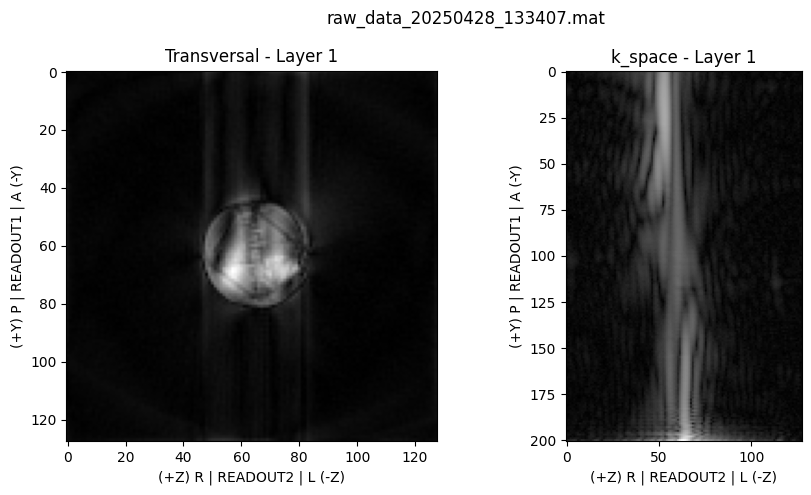

[{'widget': 'image',
  'data': array([[[1.84286352, 1.9451482 , 2.75071887, ..., 3.41403491,
           4.7210621 , 6.0198662 ],
          [0.468345  , 1.82695363, 1.94950265, ..., 3.49577502,
           4.52658444, 6.55763265],
          [1.2298779 , 1.92543966, 2.0038341 , ..., 3.12691908,
           3.62951664, 6.56833743],
          ...,
          [4.50857331, 3.16344857, 2.57176829, ..., 2.00347112,
           2.32879227, 3.37447185],
          [5.48571456, 3.73974137, 2.2679358 , ..., 1.71162895,
           2.6010213 , 3.52881733],
          [5.42078025, 4.16873051, 3.05049953, ..., 4.02887382,
           3.86533287, 4.38415271]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.92413643, -1.94283832, -1.87591033, ..., -1.98389497,
           -1.9284924 , -1.91533859],
          [-1.96186704, -1.97828874, -1.89573977, ..., -1.9341985 ,
           -1.9

In [5]:

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53223, rfExFA=90, rfSincExTime=3.0, repetitionTime=50.0, 
    echoTime=9.0, fovInPlane=250, dfov=[0.0, 0.0, 12.0], nPoints=[128, 128, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=0, riseTime=0.25, bandwidth=21.3333333333333333, 
    DephTime=2.0, shimming=[0.0018, 0.0023, 0.0003], thickness=5.0, 
    sliceGap=1.0, RFSpoilPhase=117, fsp_r=0.5, fsp_s=4   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)


Sequence total time: 0.0 min 10.05 seconds!
Acquisition bandwidth fixed to: 21.333 kHz
Creating batch_1.seq...
read 6 definitions, 1005 blocks, 2 shapes, 24 adc events, 24 rf events, 906 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 25728 read points. Sequence ready!
Center frequecy set: 10.53223 MHz
Scan 1, batch 1/1 running...
Acquired points = 77184, Expected points = 77184
Scan 1, batch 1/1 ready!
------------ max abs value: 0.7172735606849105


LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  6.06it/s, resid=3.29E-01]


(128, 128)
Moved: raw_data_20250428_133655 to experiments/acquisitions/2025.04.28


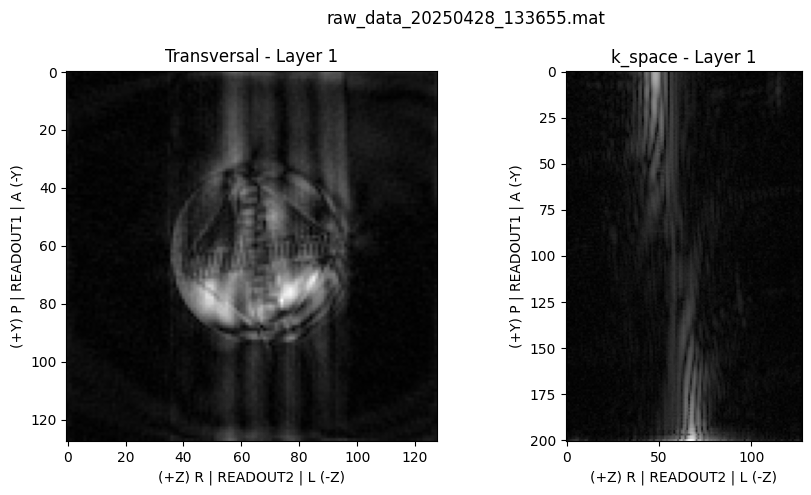

[{'widget': 'image',
  'data': array([[[ 5.88613239,  3.40893287,  4.01197769, ..., 10.64805939,
           12.66433232, 13.14400452],
          [ 5.60520313,  3.74984259,  0.54760984, ...,  6.06151558,
            6.94149688, 10.89124609],
          [ 5.56806208,  4.3113959 ,  2.22453654, ...,  9.24898045,
            7.83749132, 10.93709754],
          ...,
          [ 2.62537727,  2.73177438,  3.0003617 , ...,  3.43019838,
            6.21941486,  7.79950298],
          [ 3.95398194,  2.27229943,  2.52858559, ...,  8.24632688,
            9.61415446,  8.8474975 ],
          [ 3.6688225 ,  4.91851087,  3.27292206, ..., 12.29269301,
           10.85204028,  8.28524552]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.93408636, -1.92599618, -1.9001104 , ..., -1.92156203,
           -1.95094338, -1.94678494],
          [-1.9254752 , -1.97094663, -1.9114454

In [6]:

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53223, rfExFA=90, rfSincExTime=3.0, repetitionTime=50.0, 
    echoTime=12.0, fovInPlane=150, dfov=[0.0, 0.0, 12.0], nPoints=[128, 128, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=0, riseTime=0.25, bandwidth=21.3333333333333333, 
    DephTime=2.0, shimming=[0.0018, 0.0023, 0.0003], thickness=5.0, 
    sliceGap=1.0, RFSpoilPhase=117, fsp_r=0.5, fsp_s=4   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)


Sequence total time: 0.0 min 10.05 seconds!
Acquisition bandwidth fixed to: 21.333 kHz
Creating batch_1.seq...
read 6 definitions, 1505 blocks, 2 shapes, 24 adc events, 24 rf events, 1206 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 25728 read points. Sequence ready!
Center frequecy set: 10.53223 MHz
Scan 1, batch 1/1 running...
Acquired points = 77184, Expected points = 77184
Scan 1, batch 1/1 ready!
------------ max abs value: 0.16963399960356948


LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  5.98it/s, resid=2.65E-01]


(128, 128)
Moved: raw_data_20250428_133836 to experiments/acquisitions/2025.04.28


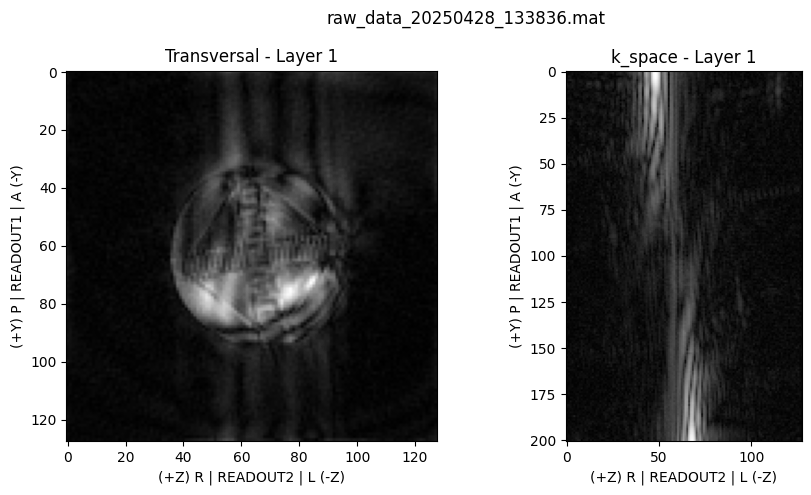

[{'widget': 'image',
  'data': array([[[ 3.89744319,  3.38566569,  2.89357394, ...,  9.99118459,
           13.07319408, 15.34501319],
          [ 6.16045814,  2.86695364,  2.87692844, ...,  9.60912254,
            9.26610979, 11.43498731],
          [ 5.09479137,  3.56418561,  2.99464044, ...,  7.47341149,
            7.56688551, 12.31455984],
          ...,
          [ 4.22606655,  2.5767163 ,  0.99754523, ...,  4.83246973,
            5.19450328,  7.90142833],
          [ 3.5060912 ,  1.15584411,  2.0182745 , ...,  8.06482015,
            8.92960132, 10.16046718],
          [ 2.62997359,  1.57165037,  3.87329841, ...,  7.4899623 ,
            9.10266386, 11.3086084 ]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.92149996, -1.93539841, -1.94861682, ..., -1.94523797,
           -1.9711622 , -1.95889588],
          [-1.9361928 , -1.97353302, -1.9528574

In [7]:

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53223, rfExFA=90, rfSincExTime=3.0, repetitionTime=50.0, 
    echoTime=12.0, fovInPlane=150, dfov=[0.0, 0.0, 12.0], nPoints=[128, 128, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=100, riseTime=0.25, bandwidth=21.3333333333333333, 
    DephTime=2.0, shimming=[0.0018, 0.0023, 0.0003], thickness=5.0, 
    sliceGap=1.0, RFSpoilPhase=117, fsp_r=0.5, fsp_s=4   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)


Sequence total time: 0.0 min 10.05 seconds!
Acquisition bandwidth fixed to: 21.333 kHz
Creating batch_1.seq...
read 6 definitions, 1005 blocks, 2 shapes, 24 adc events, 24 rf events, 906 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 25728 read points. Sequence ready!
Center frequecy set: 10.53223 MHz
Scan 1, batch 1/1 running...
Acquired points = 77184, Expected points = 77184
Scan 1, batch 1/1 ready!
------------ max abs value: 1.7917194456175083


LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  6.00it/s, resid=9.34E-01]


(128, 128)
Moved: raw_data_20250428_134501 to experiments/acquisitions/2025.04.28


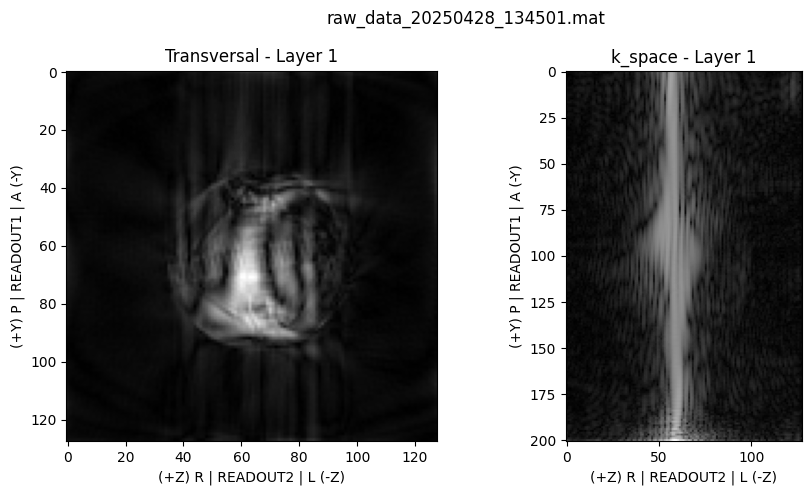

[{'widget': 'image',
  'data': array([[[5.72936153, 4.91834128, 4.33352632, ..., 6.68994096,
           7.74517761, 9.82230687],
          [5.30267244, 4.21205518, 3.8656512 , ..., 4.33227951,
           5.23463771, 7.38391664],
          [5.14738216, 3.21503679, 2.98081969, ..., 2.57739582,
           3.95297982, 6.00897573],
          ...,
          [3.60023203, 3.31473963, 3.16907549, ..., 0.55284365,
           0.54560764, 0.72056399],
          [4.10646588, 4.34091933, 3.93270937, ..., 0.63684561,
           0.44792141, 1.90694748],
          [5.96987854, 5.92763634, 5.90950189, ..., 1.12474104,
           1.62430955, 1.76067142]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.85959339, -1.91476568, -1.92101157, ..., -1.76381388,
           -1.90897218, -1.8934012 ],
          [-1.86367114, -1.94073454, -1.91718554, ..., -1.71755627,
           -1.8

In [ ]:

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53257, rfExFA=90, rfSincExTime=3.0, repetitionTime=50.0, 
    echoTime=12.0, fovInPlane=150, dfov=[0.0, 0.0, 12.0], nPoints=[128, 128, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=0, riseTime=0.25, bandwidth=21.3333333333333333, 
    DephTime=2.0, shimming=[0.0015, 0.0015, 0.0003], thickness=50.0, 
    sliceGap=1.0, RFSpoilPhase=117, fsp_r=0.5, fsp_s=4   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)


Sequence total time: 0.0 min 10.05 seconds!
Acquisition bandwidth fixed to: 21.333 kHz
Creating batch_1.seq...
read 6 definitions, 1005 blocks, 2 shapes, 24 adc events, 24 rf events, 906 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 25728 read points. Sequence ready!
Center frequecy set: 10.53263 MHz
Scan 1, batch 1/1 running...
Acquired points = 77184, Expected points = 77184
Scan 1, batch 1/1 ready!
------------ max abs value: 0.7183667839289426


LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s, resid=4.14E-01]


(128, 128)
Moved: raw_data_20250428_134614 to experiments/acquisitions/2025.04.28


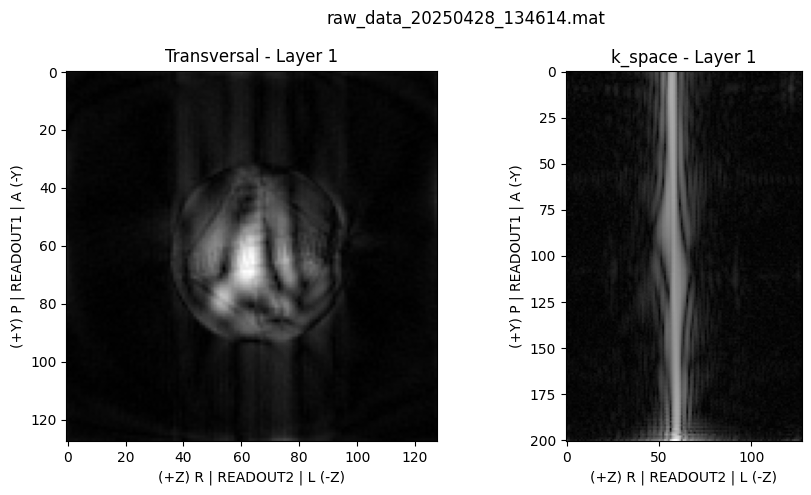

[{'widget': 'image',
  'data': array([[[5.66122011, 6.38628365, 5.82557404, ..., 5.13438045,
           6.04173619, 7.14310203],
          [4.13969815, 4.1617489 , 4.3449365 , ..., 3.1272447 ,
           3.46632201, 5.43450987],
          [4.33393192, 3.56614388, 3.91615763, ..., 2.01478389,
           3.00215488, 6.46569655],
          ...,
          [5.66270444, 3.00714786, 2.05480884, ..., 0.59277538,
           1.89476487, 0.97229483],
          [5.07164091, 3.25340163, 3.13681235, ..., 1.19933329,
           2.10507068, 1.66951762],
          [5.88919529, 4.76837348, 5.05153465, ..., 3.48113787,
           3.86975597, 3.2882487 ]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.90895392, -1.95225145, -1.93313069, ..., -1.8995382 ,
           -1.84896653, -1.8872022 ],
          [-1.9161693 , -1.95613357, -1.98016714, ..., -1.86630793,
           -1.8

In [11]:

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53263, rfExFA=90, rfSincExTime=3.0, repetitionTime=50.0, 
    echoTime=12.0, fovInPlane=150, dfov=[0.0, 0.0, 12.0], nPoints=[128, 128, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=0, riseTime=0.25, bandwidth=21.3333333333333333, 
    DephTime=2.0, shimming=[0.0015, 0.0015, 0.0003], thickness=5.0, 
    sliceGap=1.0, RFSpoilPhase=117, fsp_r=0.5, fsp_s=4   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)


Sequence total time: 0.0 min 10.05 seconds!
Acquisition bandwidth fixed to: 21.333 kHz
Creating batch_1.seq...
read 6 definitions, 1005 blocks, 2 shapes, 24 adc events, 24 rf events, 906 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 25728 read points. Sequence ready!
Center frequecy set: 10.53263 MHz
Scan 1, batch 1/1 running...


/home/lks/MaSeq_pack/marcos_client/marcompile.py:245: MarGradWarning: Gradient updates are too frequent for selected SPI divider. Missed samples are likely!
  warnings.warn("Gradient updates are too frequent for selected SPI divider. Missed samples are likely!", MarGradWarning)
/home/lks/MaSeq_pack/marcos_client/marcompile.py:309: UserWarning: NOTE: Fewer than 1000 removed-instruction warnings will not be printed -- keep this in mind when searching for the root cause.
  warnings.warn("NOTE: Fewer than {:d} removed-instruction warnings will not be printed -- keep this in mind when searching for the root cause.".format(max_removed_instructions))
/home/lks/MaSeq_pack/marcos_client/server_comms.py:86: MarServerWarning: ocra1 data was lost (overwritten before being sent)
  warnings.warn(k, MarServerWarning)


Acquired points = 77184, Expected points = 77184
Scan 1, batch 1/1 ready!
------------ max abs value: 0.7513842288284415


LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  6.00it/s, resid=4.18E-01]


(128, 128)
Moved: raw_data_20250428_134804 to experiments/acquisitions/2025.04.28


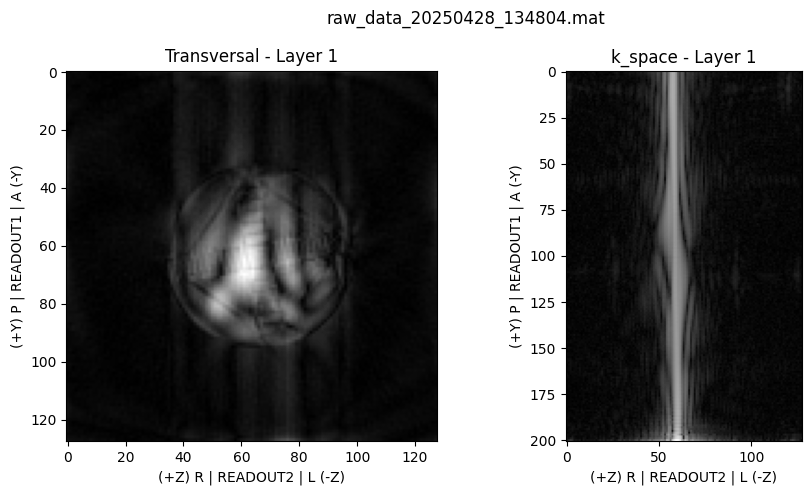

[{'widget': 'image',
  'data': array([[[4.04240013, 3.00195278, 5.28961768, ..., 7.0048623 ,
           7.95694442, 8.99764371],
          [4.17576458, 3.56378234, 2.91220086, ..., 4.68813929,
           5.53618146, 6.66978989],
          [3.59731399, 3.54014219, 2.27491438, ..., 3.49931146,
           4.44172614, 6.69614842],
          ...,
          [3.84069942, 2.66579827, 2.56438791, ..., 3.15002231,
           3.06092498, 3.26290407],
          [5.18744716, 4.33978333, 4.5692744 , ..., 4.32499964,
           4.75426773, 6.30866864],
          [7.69786029, 5.70969813, 5.30152221, ..., 6.49494225,
           6.04539034, 9.15037941]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.90401155, -1.87280045, -1.9549414 , ..., -1.95428649,
           -1.96850774, -1.93670016],
          [-1.84221788, -1.84225005, -1.89736825, ..., -1.91456218,
           -1.9

In [13]:
# use pre-emphasis

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53263, rfExFA=90, rfSincExTime=3.0, repetitionTime=50.0, 
    echoTime=12.0, fovInPlane=150, dfov=[0.0, 0.0, 12.0], nPoints=[128, 128, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=0, riseTime=0.25, bandwidth=21.3333333333333333, 
    DephTime=2.0, shimming=[0.0015, 0.0015, 0.0003], thickness=5.0, 
    sliceGap=1.0, RFSpoilPhase=117, fsp_r=0.5, fsp_s=4   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)



TotalVariationRecon: 100%|██████████| 100/100 [00:16<00:00,  6.06it/s, resid=1.70E-02]


(128, 128)


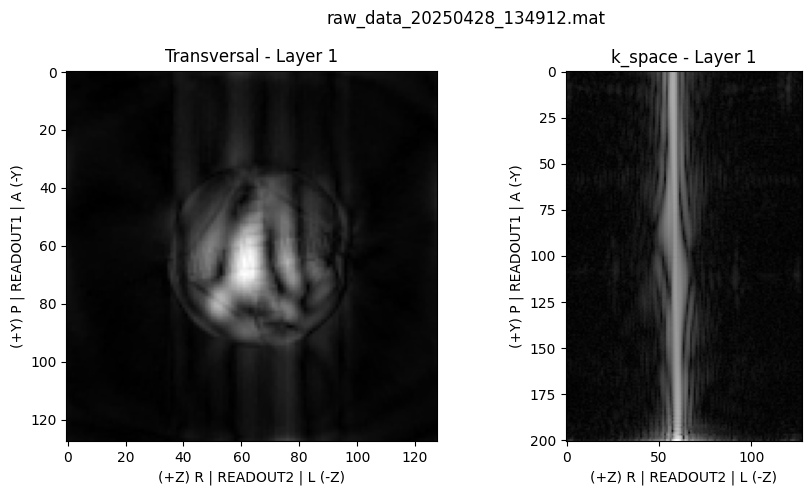

[{'widget': 'image',
  'data': array([[[2.39580348, 1.98113124, 2.9654348 , ..., 4.24755194,
           4.6685605 , 5.01962415],
          [2.42549415, 2.10865742, 2.13552239, ..., 2.98484467,
           3.42653374, 4.09740996],
          [2.29980699, 2.12371209, 1.66784993, ..., 1.99298046,
           2.5863939 , 3.67734818],
          ...,
          [3.0859875 , 2.54660979, 2.06035016, ..., 1.41986804,
           1.42558985, 1.46957615],
          [3.84266355, 3.50050995, 3.42069282, ..., 2.20395649,
           2.45376427, 3.35279715],
          [5.19834659, 4.16134748, 3.60208979, ..., 3.40777241,
           3.1348608 , 4.76978508]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.90401155, -1.87280045, -1.9549414 , ..., -1.95428649,
           -1.96850774, -1.93670016],
          [-1.84221788, -1.84225005, -1.89736825, ..., -1.91456218,
           -1.9

In [14]:
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.1)


Sequence total time: 0.0 min 10.05 seconds!
Acquisition bandwidth fixed to: 21.333 kHz
Creating batch_1.seq...
read 6 definitions, 1005 blocks, 2 shapes, 24 adc events, 24 rf events, 906 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 25728 read points. Sequence ready!
Center frequecy set: 10.53263 MHz
Scan 1, batch 1/1 running...


/home/lks/MaSeq_pack/marcos_client/marcompile.py:245: MarGradWarning: Gradient updates are too frequent for selected SPI divider. Missed samples are likely!
  warnings.warn("Gradient updates are too frequent for selected SPI divider. Missed samples are likely!", MarGradWarning)
/home/lks/MaSeq_pack/marcos_client/marcompile.py:309: UserWarning: NOTE: Fewer than 1000 removed-instruction warnings will not be printed -- keep this in mind when searching for the root cause.
  warnings.warn("NOTE: Fewer than {:d} removed-instruction warnings will not be printed -- keep this in mind when searching for the root cause.".format(max_removed_instructions))
/home/lks/MaSeq_pack/marcos_client/server_comms.py:86: MarServerWarning: ocra1 data was lost (overwritten before being sent)
  warnings.warn(k, MarServerWarning)


Acquired points = 77184, Expected points = 77184
Scan 1, batch 1/1 ready!
------------ max abs value: 0.7973099940827485


LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  6.03it/s, resid=4.28E-01]


(128, 128)
Moved: raw_data_20250428_135050 to experiments/acquisitions/2025.04.28


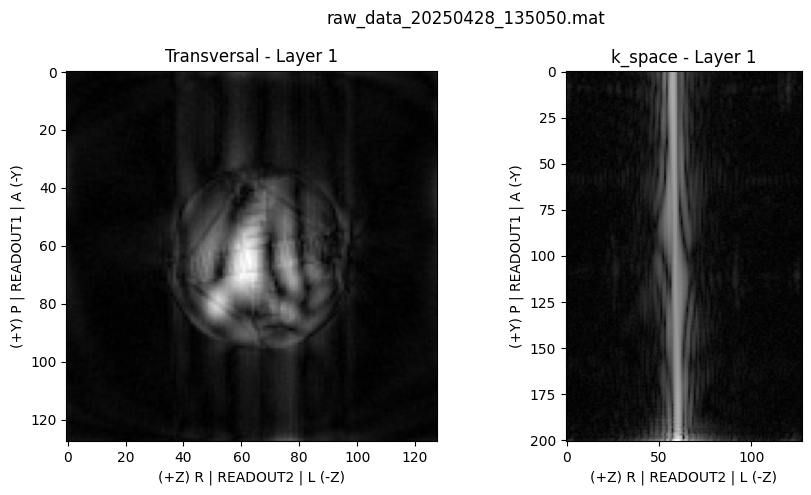

[{'widget': 'image',
  'data': array([[[ 4.43531665,  5.51676637,  5.66457369, ...,  8.57619864,
            8.41243191, 10.23748562],
          [ 4.47908614,  4.96825648,  4.23406048, ...,  4.3650147 ,
            5.50535857,  8.28500189],
          [ 3.74171268,  3.72954305,  4.73049526, ...,  1.95172795,
            5.65461683,  8.23227284],
          ...,
          [ 5.21328573,  3.43896547,  3.08415976, ...,  2.38989131,
            3.01876924,  2.36513825],
          [ 6.37906138,  4.18601199,  5.4539492 , ...,  3.84286397,
            4.67972811,  3.37744864],
          [ 7.84037284,  6.40030726,  7.97842482, ...,  6.76531819,
            7.00033074,  8.44761228]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.90409253, -1.86015226, -1.97606647, ..., -1.90070197,
           -1.94705841, -1.93139413],
          [-1.8492196 , -1.88856022, -1.8927870

In [3]:
# use pre-emphasis

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53263, rfExFA=90, rfSincExTime=3.0, repetitionTime=50.0, 
    echoTime=12.0, fovInPlane=150, dfov=[0.0, 0.0, 12.0], nPoints=[128, 128, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=0, riseTime=0.25, bandwidth=21.3333333333333333, 
    DephTime=2.0, shimming=[0.0015, 0.0015, 0.0003], thickness=5.0, 
    sliceGap=1.0, RFSpoilPhase=117, fsp_r=0.5, fsp_s=4   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)



Sequence total time: 0.0 min 30.15 seconds!
Acquisition bandwidth fixed to: 21.333 kHz
Creating batch_1.seq...
read 6 definitions, 1005 blocks, 2 shapes, 24 adc events, 24 rf events, 906 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 25728 read points. Sequence ready!
Center frequecy set: 10.53263 MHz
Scan 1, batch 1/1 running...


/home/lks/MaSeq_pack/marcos_client/marcompile.py:245: MarGradWarning: Gradient updates are too frequent for selected SPI divider. Missed samples are likely!
  warnings.warn("Gradient updates are too frequent for selected SPI divider. Missed samples are likely!", MarGradWarning)
/home/lks/MaSeq_pack/marcos_client/marcompile.py:309: UserWarning: NOTE: Fewer than 1000 removed-instruction warnings will not be printed -- keep this in mind when searching for the root cause.
  warnings.warn("NOTE: Fewer than {:d} removed-instruction warnings will not be printed -- keep this in mind when searching for the root cause.".format(max_removed_instructions))
/home/lks/MaSeq_pack/marcos_client/server_comms.py:86: MarServerWarning: ocra1 data was lost (overwritten before being sent)
  warnings.warn(k, MarServerWarning)


Acquired points = 77184, Expected points = 77184
Scan 1, batch 1/1 ready!
------------ max abs value: 0.8205720764391516


LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  5.97it/s, resid=7.79E-01]


(128, 128)
Moved: raw_data_20250428_135227 to experiments/acquisitions/2025.04.28


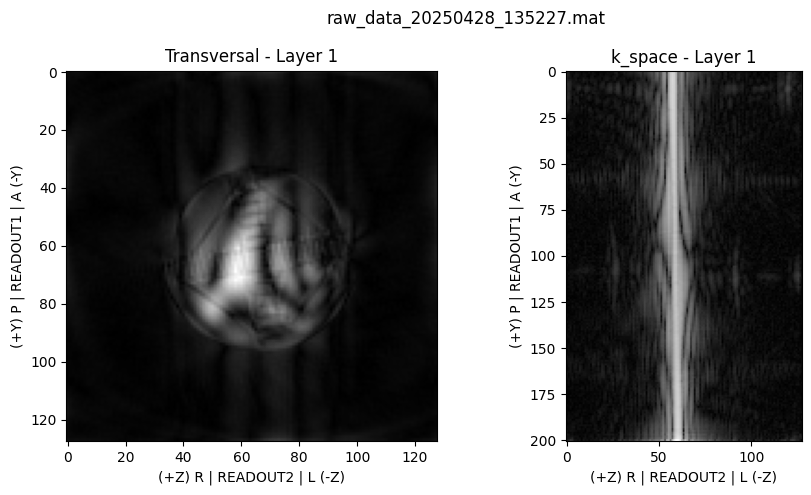

[{'widget': 'image',
  'data': array([[[5.05395299, 4.47410709, 5.4851086 , ..., 6.86651071,
           7.90369617, 9.92045869],
          [4.20607924, 3.84018948, 3.9998069 , ..., 3.81372343,
           5.12633134, 7.76120613],
          [3.25374512, 3.25892856, 2.62882734, ..., 2.30205352,
           3.88700954, 7.01528065],
          ...,
          [3.75027335, 3.25423643, 2.64512296, ..., 1.88782492,
           3.22940296, 4.28757141],
          [4.14319104, 3.10561968, 3.03112748, ..., 2.65895027,
           3.84148154, 5.27230004],
          [5.98790917, 4.44271996, 4.50512828, ..., 5.61315676,
           6.58984905, 7.94912557]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.77004324, -1.8011251 , -1.86987878, ..., -1.92977608,
           -1.87422643, -1.87684574],
          [-1.77607933, -1.76982209, -1.90289877, ..., -1.86940919,
           -1.9

In [4]:
# use pre-emphasis

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53263, rfExFA=90, rfSincExTime=3.0, repetitionTime=150.0, 
    echoTime=12.0, fovInPlane=150, dfov=[0.0, 0.0, 12.0], nPoints=[128, 128, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=0, riseTime=0.25, bandwidth=21.3333333333333333, 
    DephTime=2.0, shimming=[0.0015, 0.0015, 0.0003], thickness=5.0, 
    sliceGap=1.0, RFSpoilPhase=117, fsp_r=0.5, fsp_s=4   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)



Sequence total time: 0.0 min 20.1 seconds!
Acquisition bandwidth fixed to: 21.333 kHz
Creating batch_1.seq...
read 6 definitions, 2010 blocks, 2 shapes, 24 adc events, 24 rf events, 1204 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 102912 read points. Sequence ready!
Center frequecy set: 10.5334 MHz
Scan 1, batch 1/1 running...
Acquired points = 308736, Expected points = 308736
Scan 1, batch 1/1 ready!
------------ max abs value: 0.822567053304625


LinearLeastSquares: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s, resid=8.28E-01]


(256, 256)
Moved: raw_data_20250428_140318 to experiments/acquisitions/2025.04.28


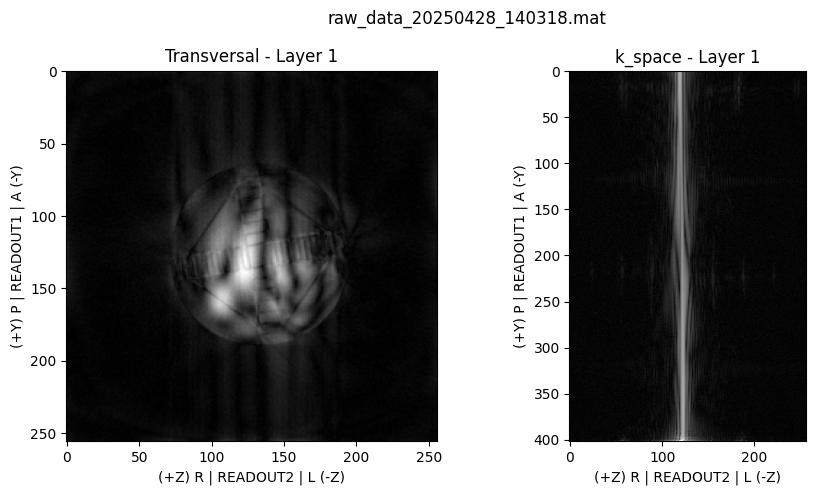

[{'widget': 'image',
  'data': array([[[7.90440253, 7.72965619, 8.3625087 , ..., 4.40795674,
           4.47027867, 5.24407587],
          [7.28021336, 6.6149234 , 6.92335994, ..., 4.40298486,
           3.8800005 , 5.0701562 ],
          [7.26573088, 5.59740627, 5.61421813, ..., 3.13017712,
           4.07556852, 5.29647679],
          ...,
          [5.25104917, 5.14932197, 3.25068405, ..., 2.25474065,
           1.96696999, 0.80218622],
          [4.94166038, 3.57992861, 4.49080056, ..., 2.21338814,
           2.36951023, 2.10122641],
          [5.60288968, 3.6380822 , 5.05528962, ..., 3.12942208,
           3.18917412, 3.29861608]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.95776436, -1.9350342 , -1.98377848, ..., -1.9273414 ,
           -1.92292046, -1.97452972],
          [-1.97399375, -1.92009934, -1.9615595 , ..., -1.97024711,
           -1.9

In [6]:
# use pre-emphasis

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53340, rfExFA=90, rfSincExTime=3.0, repetitionTime=50.0, 
    echoTime=12.0, fovInPlane=150, dfov=[0.0, 0.0, 12.0], nPoints=[256, 256, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=0, riseTime=0.25, bandwidth=21.3333333333333333, 
    DephTime=2.0, shimming=[0.0015, 0.0015, 0.0003], thickness=5.0, 
    sliceGap=1.0, RFSpoilPhase=117, fsp_r=0.5, fsp_s=4   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)



Sequence total time: 0.0 min 20.1 seconds!
Acquisition bandwidth fixed to: 21.333 kHz
Creating batch_1.seq...
read 6 definitions, 2010 blocks, 2 shapes, 24 adc events, 24 rf events, 1206 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 102912 read points. Sequence ready!
Center frequecy set: 10.5334 MHz
Scan 1, batch 1/1 running...
Acquired points = 308736, Expected points = 308736
Scan 1, batch 1/1 ready!
------------ max abs value: 0.8641257702075764


LinearLeastSquares: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s, resid=6.23E-01]


(256, 256)
Moved: raw_data_20250428_140424 to experiments/acquisitions/2025.04.28


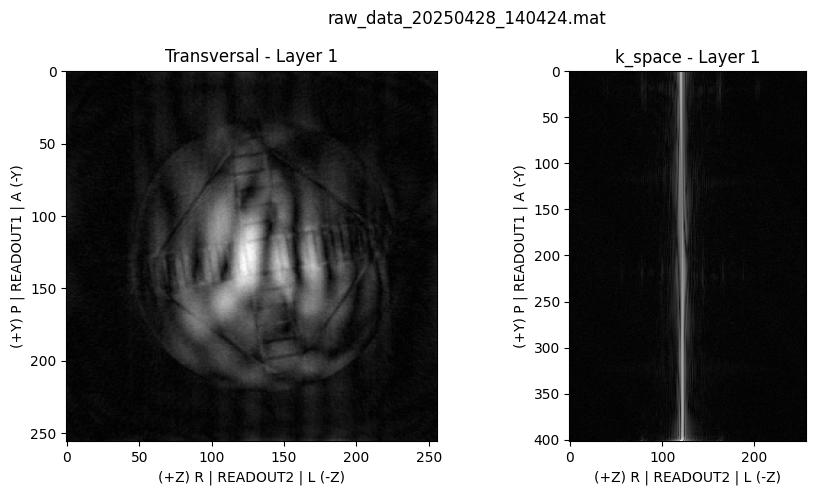

[{'widget': 'image',
  'data': array([[[11.25532132,  9.72680698,  8.24110995, ...,  7.06382296,
            6.89898002,  8.58662044],
          [10.62299856,  8.96101078,  8.69268331, ...,  7.71045711,
            7.96439198,  8.80094947],
          [ 4.66501072,  4.02458754,  4.452481  , ...,  7.15075638,
            6.80291797,  9.00423948],
          ...,
          [ 3.75121459,  3.92140274,  2.82091447, ...,  2.30938223,
            0.92338656,  2.90785534],
          [ 2.41136032,  2.67081288,  2.02268752, ...,  2.9242472 ,
            2.64558569,  3.33338264],
          [ 3.76740023,  3.27051951,  3.86216025, ...,  3.94272045,
            5.02384687,  6.35142312]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.94902486, -1.96460295, -1.95083838, ..., -1.97341693,
           -1.95195632, -1.96853876],
          [-1.96517224, -1.95001132, -1.9654902

In [7]:
# use pre-emphasis

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53340, rfExFA=90, rfSincExTime=3.0, repetitionTime=50.0, 
    echoTime=12.0, fovInPlane=100, dfov=[0.0, 0.0, 12.0], nPoints=[256, 256, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=0, riseTime=0.25, bandwidth=21.3333333333333333, 
    DephTime=2.0, shimming=[0.0015, 0.0015, 0.0003], thickness=5.0, 
    sliceGap=1.0, RFSpoilPhase=117, fsp_r=0.5, fsp_s=4   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)



Sequence total time: 0.0 min 10.05 seconds!
Acquisition bandwidth fixed to: 21.333 kHz
Creating batch_1.seq...
read 6 definitions, 1005 blocks, 2 shapes, 1 adc events, 1 rf events, 906 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 25728 read points. Sequence ready!
Center frequecy set: 10.5334 MHz
Scan 1, batch 1/1 running...
Acquired points = 77184, Expected points = 77184
Scan 1, batch 1/1 ready!
------------ max abs value: 0.8242689726064178


LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  6.04it/s, resid=2.85E-01]


(128, 128)
Moved: raw_data_20250428_140532 to experiments/acquisitions/2025.04.28


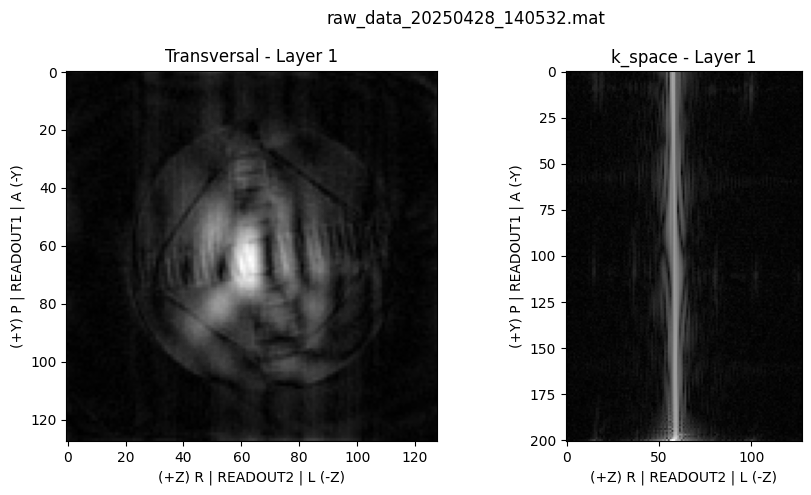

[{'widget': 'image',
  'data': array([[[3.57765148, 4.73795687, 5.74883195, ..., 2.06238051,
           2.20960675, 3.91104083],
          [1.37469632, 2.09002234, 3.67667745, ..., 2.17913621,
           1.67066849, 4.56701959],
          [2.80209416, 3.88480263, 3.85024755, ..., 2.29213757,
           3.2190301 , 4.57588168],
          ...,
          [5.76871889, 4.99961611, 2.44123927, ..., 1.91668696,
           1.6137688 , 1.60182398],
          [7.47308803, 5.48294816, 2.63030316, ..., 0.85366649,
           0.24926849, 1.69781828],
          [8.29961587, 4.6960834 , 4.54353512, ..., 1.42707104,
           0.80575841, 1.89567068]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.94995637, -1.95647181, -1.9298946 , ..., -1.97502905,
           -1.9434518 , -1.98522956],
          [-1.88542935, -1.96417835, -1.97273853, ..., -1.93121209,
           -1.9

In [8]:
# use pre-emphasis

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53340, rfExFA=90, rfSincExTime=3.0, repetitionTime=50.0, 
    echoTime=12.0, fovInPlane=100, dfov=[0.0, 0.0, 12.0], nPoints=[128, 128, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=0, riseTime=0.25, bandwidth=21.3333333333333333, 
    DephTime=2.0, shimming=[0.0015, 0.0015, 0.0003], thickness=5.0, 
    sliceGap=1.0, RFSpoilPhase=0, fsp_r=0.5, fsp_s=4   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)



Sequence total time: 0.0 min 10.05 seconds!
Acquisition bandwidth fixed to: 21.333 kHz
Creating batch_1.seq...
read 6 definitions, 1005 blocks, 2 shapes, 24 adc events, 24 rf events, 906 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 25728 read points. Sequence ready!
Center frequecy set: 10.5334 MHz
Scan 1, batch 1/1 running...
Acquired points = 77184, Expected points = 77184
Scan 1, batch 1/1 ready!
------------ max abs value: 0.8334143437756321


LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  5.97it/s, resid=2.86E-01]


(128, 128)
Moved: raw_data_20250428_140615 to experiments/acquisitions/2025.04.28


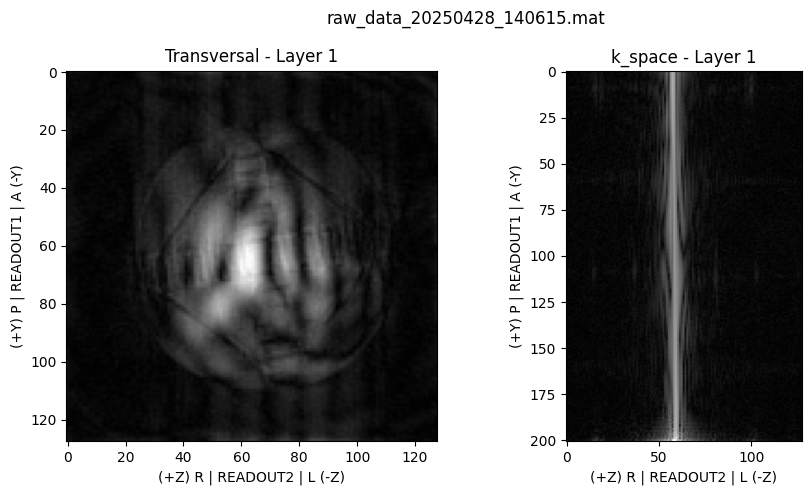

[{'widget': 'image',
  'data': array([[[1.43465133, 6.72631174, 4.20787706, ..., 4.28352818,
           4.61559005, 5.27778758],
          [1.40121231, 5.16028087, 3.68814569, ..., 2.65315777,
           2.38958805, 4.29690317],
          [1.63826342, 4.19523977, 4.38830258, ..., 4.3137879 ,
           2.13581963, 0.63478321],
          ...,
          [4.88446354, 4.57193379, 2.84678939, ..., 1.44361339,
           1.61542704, 2.25829388],
          [6.1213304 , 6.1968737 , 3.62731215, ..., 1.11231202,
           1.86138916, 1.72739038],
          [7.72757043, 5.12305797, 3.30078461, ..., 4.09618679,
           2.66101975, 1.63953689]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.9826262 , -1.98560448, -1.95934139, ..., -1.94987416,
           -1.96382597, -1.95416119],
          [-1.96437976, -1.97755321, -1.948752  , ..., -1.97161975,
           -1.9

In [9]:
# use pre-emphasis

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53340, rfExFA=90, rfSincExTime=3.0, repetitionTime=50.0, 
    echoTime=12.0, fovInPlane=100, dfov=[0.0, 0.0, 12.0], nPoints=[128, 128, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=0, riseTime=0.25, bandwidth=21.3333333333333333, 
    DephTime=2.0, shimming=[0.0015, 0.0015, 0.0003], thickness=5.0, 
    sliceGap=1.0, RFSpoilPhase=117, fsp_r=0.5, fsp_s=0   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)



Sequence total time: 0.0 min 10.05 seconds!
Acquisition bandwidth fixed to: 21.333 kHz
Creating batch_1.seq...
read 6 definitions, 1005 blocks, 2 shapes, 1 adc events, 1 rf events, 906 gradient shapes
gre_radial_batch_1.seq ready!
1 batches created with 25728 read points. Sequence ready!
Center frequecy set: 10.53446 MHz
Scan 1, batch 1/1 running...


/home/lks/MaSeq_pack/marcos_client/marcompile.py:245: MarGradWarning: Gradient updates are too frequent for selected SPI divider. Missed samples are likely!
  warnings.warn("Gradient updates are too frequent for selected SPI divider. Missed samples are likely!", MarGradWarning)
/home/lks/MaSeq_pack/marcos_client/server_comms.py:86: MarServerWarning: ocra1 data was lost (overwritten before being sent)
  warnings.warn(k, MarServerWarning)


Acquired points = 77184, Expected points = 77184
Scan 1, batch 1/1 ready!
------------ max abs value: 0.8517056960738832


LinearLeastSquares: 100%|██████████| 10/10 [00:01<00:00,  6.00it/s, resid=3.54E-01]


(128, 128)
Moved: raw_data_20250428_143203 to experiments/acquisitions/2025.04.28


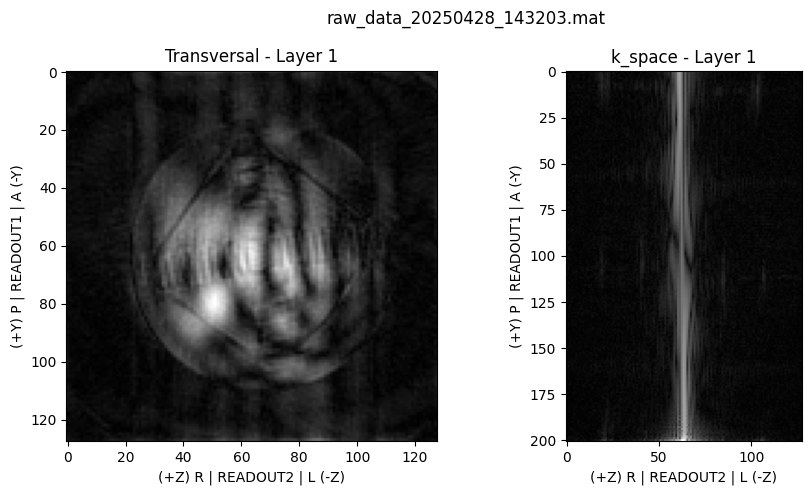

[{'widget': 'image',
  'data': array([[[ 4.00010379,  2.37413937,  3.68376611, ...,  8.16291892,
            7.7868522 , 13.16639161],
          [ 4.6820762 ,  4.33392672,  2.58277307, ...,  1.95928662,
            3.24290442,  7.9237403 ],
          [ 5.05865832,  7.21671994,  4.83272395, ..., 11.16439661,
            7.18524286,  6.66965698],
          ...,
          [ 4.57980565,  4.70856134,  4.16732313, ...,  0.41198929,
            2.27216852,  4.66042759],
          [ 7.75930738,  5.49888406,  3.12745279, ...,  2.60537677,
            2.10394697,  1.25400846],
          [ 9.20790204,  6.91647423,  6.52724296, ...,  5.01940913,
            6.48001072,  4.46798945]]]),
  'xLabel': '(+Z) R | READOUT2 | L (-Z)',
  'yLabel': '(+Y) P | READOUT1 | A (-Y)',
  'title': 'Transversal',
  'row': 0,
  'col': 0},
 {'widget': 'image',
  'data': array([[[-1.97149075, -1.9728762 , -1.95924294, ..., -1.92971553,
           -1.96679143, -1.92679774],
          [-1.9819728 , -1.95726036, -1.9682556

In [11]:
# use pre-emphasis

seq = GRERadialPSEQ(
    nScans=1, larmorFreq=10.53446, rfExFA=90, rfSincExTime=3.0, repetitionTime=50.0, 
    echoTime=12.0, fovInPlane=100, dfov=[0.0, 0.0, 12.0], nPoints=[128, 128, 1], 
    axesOrientation=[1, 2, 0], dummyPulses=0, riseTime=0.25, bandwidth=21.3333333333333333, 
    DephTime=2.0, shimming=[0.0015, 0.0015, 0.0003], thickness=5.0, 
    sliceGap=1.0, RFSpoilPhase=0, fsp_r=0.5, fsp_s=4, gx_comp=0.47   
)

print(f"Sequence total time: {seq.sequenceTime() * 60 // 60} min {seq.sequenceTime() * 60 % 60} seconds!" )
seq.sequenceAtributes()
seq.sequenceRun(plotSeq=False, demo=False, standalone=True)
print(f'------------ max abs value: {np.abs(seq.mapVals['data_full']).max()}')
seq.sequenceAnalysis(mode='Standalone', lambda_tv=0.0)

